# Описание данных и задачи

**Шаг 1.** Создать таблицу, используя csv-файл Hotel.csv

Описание таблицы logs_hotel:

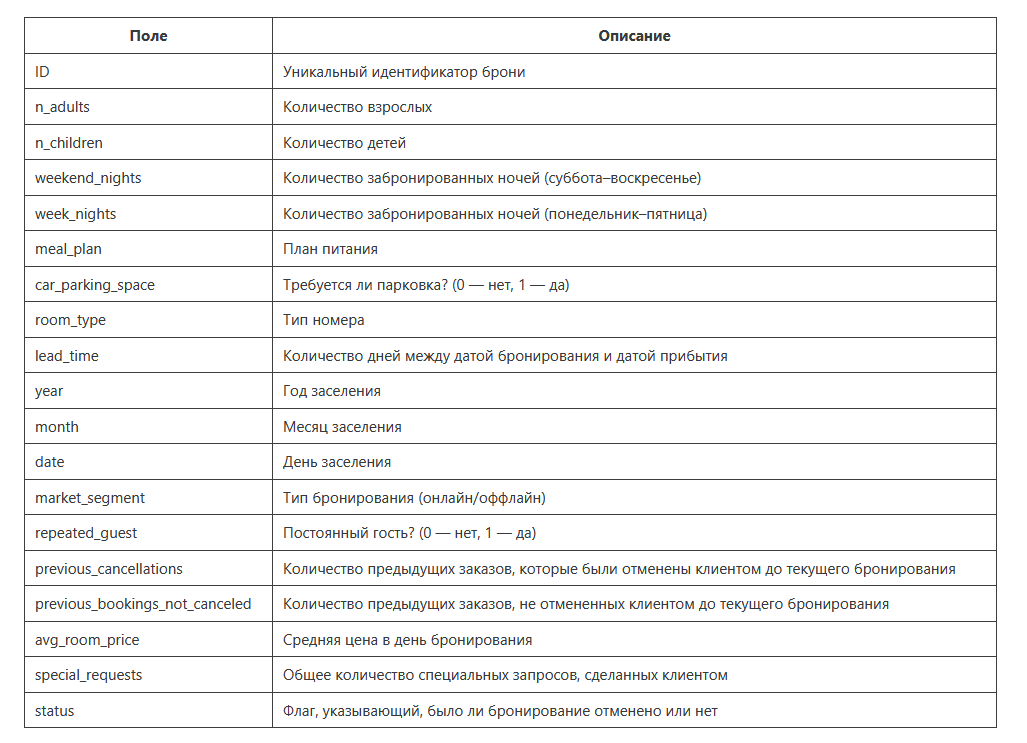

**Шаг 2.** Создать (сгенерировать) таблицу calendar, который будет состоять из одного поля calendar_dt со всеми днями с 2017-01-01 по 2018-12-31.

Описание таблицы calendar:
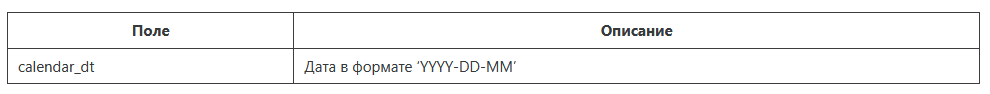


**Шаг 3.** Выполнить следующие запросы:

  1. Вычислить среднее количество ночей, которые гости проводят в отеле (только для подтвержденных бронирований, с детализацией по месяцам и годам)
  2. Определить ТОП-3 месяца по проценту отмененных броней за 2018 год.
  3. Вычислить среднее время на каждый месяц между бронированием и заездом в отель для подтвержденных броней.
  4. Вычислить общую среднюю выручку на каждый месяц в каждом году, сгруппировав по всем типам бронирования для подтвержденных броней, и вывести это в виде сводной таблицы (PIVOT).
  5. Выявить ТОП-5 постоянных гостей, которые принесли наибольшую выручку за все время, и показать их долю в общей выручке от постоянных гостей. Использовать уникальный идентификатор брони как уникальный идентификатор гостя, предположив, что 1 бронь = 1 гость.
  6. Вывести общее количество гостей на каждый день в отеле, отсортировав по убыванию дат, включая дни, когда отель пустует. Также рассчитать процент загрузки для каждого дня, если известно, что общая вместимость отеля 400 человек.

# Решение

## Шаг 1.

Создание таблицы logs_hotel

In [1]:
!pip install pyspark

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
from pyspark.sql.functions import *
from pyspark.sql.types import *

# создание спарк сессии
spark = SparkSession.builder.appName("Hotel Logs").config('spark.sql.shuffle.partitions', '4').getOrCreate()

# создание таблицы logs_hotel
logs_hotel = spark.read.option("header", "true").option("inferSchema", "true").csv("Hotel.csv")
logs_hotel.show(5, False)

+--------+--------+----------+--------------+-----------+------------+-----------------+-----------+---------+----+-----+----+--------------+--------------+----------------------+------------------------------+--------------+----------------+------------+
|ID      |n_adults|n_children|weekend_nights|week_nights|meal_plan   |car_parking_space|room_type  |lead_time|year|month|date|market_segment|repeated_guest|previous_cancellations|previous_bookings_not_canceled|avg_room_price|special_requests|status      |
+--------+--------+----------+--------------+-----------+------------+-----------------+-----------+---------+----+-----+----+--------------+--------------+----------------------+------------------------------+--------------+----------------+------------+
|INN00001|2       |0         |1             |2          |Meal Plan 1 |0                |Room_Type 1|224      |2017|10   |2   |Offline       |0             |0                     |0                             |65.0          |0      

## Шаг 2

Создать (сгенерировать) таблицу calendar, который будет состоять из одного поля calendar_dt со всеми днями с 2017-01-01 по 2018-12-31



In [3]:
from datetime import datetime, timedelta

start_date = datetime(2017, 1, 1)
end_date = datetime(2018, 12, 31)
date_list = []

current_date = start_date
while current_date <= end_date:
    # формат YYYY-DD-MM
    date_str = f"{current_date.year}-{current_date.day:02d}-{current_date.month:02d}"
    date_list.append((date_str,))
    current_date += timedelta(days=1)

calendar = spark.createDataFrame(date_list, ["calendar_dt"])
calendar.show(10, False)

+-----------+
|calendar_dt|
+-----------+
|2017-01-01 |
|2017-02-01 |
|2017-03-01 |
|2017-04-01 |
|2017-05-01 |
|2017-06-01 |
|2017-07-01 |
|2017-08-01 |
|2017-09-01 |
|2017-10-01 |
+-----------+
only showing top 10 rows


## Шаг 3. Выполнение запросов

### 1. Вычислить среднее количество ночей, которые гости проводят в отеле (только для подтвержденных бронирований, с детализацией по месяцам и годам)

In [4]:
# total_nights = weekend_nights + week_nights
query1 = logs_hotel \
    .filter(f.col('status') == 'Not_Canceled') \
    .withColumn('total_nights', f.col('weekend_nights') + f.col('week_nights')) \
    .groupBy('year', 'month') \
    .agg(
        f.round(f.avg('total_nights'), 2).alias('avg_nights'),
        f.count('*').alias('bookings_count')
    ) \
    .orderBy('year', 'month')

query1.show(30, False)

+----+-----+----------+--------------+
|year|month|avg_nights|bookings_count|
+----+-----+----------+--------------+
|2017|7    |3.02      |120           |
|2017|8    |2.72      |829           |
|2017|9    |2.66      |1467          |
|2017|10   |2.7       |1611          |
|2017|11   |2.72      |620           |
|2017|12   |3.04      |906           |
|2018|1    |2.74      |990           |
|2018|2    |2.69      |1274          |
|2018|3    |3.04      |1658          |
|2018|4    |2.92      |1741          |
|2018|5    |2.81      |1650          |
|2018|6    |2.6       |1912          |
|2018|7    |3.19      |1486          |
|2018|8    |3.15      |1496          |
|2018|9    |2.79      |1606          |
|2018|10   |2.89      |1826          |
|2018|11   |2.98      |1485          |
|2018|12   |3.25      |1713          |
+----+-----+----------+--------------+



### 2. Определить ТОП-3 месяца по проценту отмененных броней за 2018 год.

In [5]:
query2 = logs_hotel \
    .filter(f.col('year') == 2018) \
    .groupBy('month') \
    .agg(
        f.count('*').alias('total_bookings'),
        # отмены
        f.sum(f.when(f.col('status') == 'Canceled', 1).otherwise(0)).alias('canceled_bookings')
    ) \
    .withColumn(
        'cancellation_rate_percent',
        f.round((f.col('canceled_bookings') / f.col('total_bookings')) * 100, 2)
    ) \
    .orderBy(f.desc('cancellation_rate_percent')) \
    .limit(3)

query2.show()

+-----+--------------+-----------------+-------------------------+
|month|total_bookings|canceled_bookings|cancellation_rate_percent|
+-----+--------------+-----------------+-------------------------+
|    8|          2799|             1303|                    46.55|
|   10|          3404|             1578|                    46.36|
|    9|          2962|             1356|                    45.78|
+-----+--------------+-----------------+-------------------------+



### 3. Вычислить среднее время на каждый месяц между бронированием и заездом в отель для подтвержденных броней.

In [6]:
query3 = logs_hotel \
    .filter(f.col('status') == 'Not_Canceled') \
    .groupBy('year', 'month') \
    .agg(
        f.round(f.avg('lead_time'), 2).alias('avg_lead_time_days'),
        f.count('*').alias('bookings_count')
    ) \
    .orderBy('year', 'month')

query3.show(30, False)

+----+-----+------------------+--------------+
|year|month|avg_lead_time_days|bookings_count|
+----+-----+------------------+--------------+
|2017|7    |130.73            |120           |
|2017|8    |35.08             |829           |
|2017|9    |51.72             |1467          |
|2017|10   |55.89             |1611          |
|2017|11   |33.28             |620           |
|2017|12   |46.75             |906           |
|2018|1    |34.87             |990           |
|2018|2    |30.53             |1274          |
|2018|3    |43.19             |1658          |
|2018|4    |62.49             |1741          |
|2018|5    |60.99             |1650          |
|2018|6    |70.64             |1912          |
|2018|7    |86.88             |1486          |
|2018|8    |83.09             |1496          |
|2018|9    |63.32             |1606          |
|2018|10   |73.24             |1826          |
|2018|11   |44.25             |1485          |
|2018|12   |69.75             |1713          |
+----+-----+-

### 4. Вычислить общую среднюю выручку на каждый месяц в каждом году, сгруппировав по всем типам бронирования для подтвержденных броней, и вывести это в виде сводной таблицы (PIVOT).

In [7]:
# пподготовка данных
# выручка = средняя цена х всего ночей
query4_base = logs_hotel \
    .filter(f.col('status') == 'Not_Canceled') \
    .withColumn('total_nights', f.col('weekend_nights') + f.col('week_nights')) \
    .withColumn('revenue', f.col('avg_room_price') * f.col('total_nights'))

# PIVOT
query4 = query4_base \
    .groupBy('year', 'month') \
    .pivot('market_segment') \
    .agg(f.round(f.avg('revenue'), 2)) \
    .orderBy('year', 'month')

query4.show(30, False)

+----+-----+--------+-------------+---------+-------+------+
|year|month|Aviation|Complementary|Corporate|Offline|Online|
+----+-----+--------+-------------+---------+-------+------+
|2017|7    |NULL    |22.4         |113.75   |228.95 |290.56|
|2017|8    |NULL    |0.32         |156.42   |235.54 |284.21|
|2017|9    |NULL    |16.89        |177.83   |236.65 |348.55|
|2017|10   |NULL    |1.09         |180.26   |223.24 |311.47|
|2017|11   |NULL    |14.81        |102.97   |198.36 |240.52|
|2017|12   |NULL    |0.25         |141.11   |253.86 |258.93|
|2018|1    |NULL    |2.27         |113.03   |210.51 |236.09|
|2018|2    |352.0   |1.39         |115.06   |251.85 |238.07|
|2018|3    |118.33  |38.17        |142.39   |233.39 |301.71|
|2018|4    |321.81  |0.0          |108.42   |236.44 |320.08|
|2018|5    |262.5   |0.0          |229.5    |274.55 |352.34|
|2018|6    |247.0   |0.0          |148.13   |251.98 |335.03|
|2018|7    |79.0    |5.38         |146.99   |310.36 |390.05|
|2018|8    |NULL    |0.0

### 5. Выявить ТОП-5 постоянных гостей, которые принесли наибольшую выручку за все время, и показать их долю в общей выручке от постоянных гостей. Использовать уникальный идентификатор брони как уникальный идентификатор гостя, предположив, что 1 бронь = 1 гость.

In [8]:
# фильтруем постоянных гостей и считаем выручку
repeated_guests = logs_hotel \
    .filter(f.col('repeated_guest') == 1) \
    .withColumn('total_nights', f.col('weekend_nights') + f.col('week_nights')) \
    .withColumn('revenue', f.col('avg_room_price') * f.col('total_nights'))

# группируем по гостю (ID)
guest_revenue = repeated_guests \
    .groupBy('ID') \
    .agg(
        f.round(f.sum('revenue'), 2).alias('total_revenue'),
        f.count('*').alias('bookings_count')
    ) \
    .orderBy(f.desc('total_revenue'))

# ТОП-5
top5_guests = guest_revenue.limit(5)

# общая выручка от всех постоянных гостейй
total_repeated_revenue = guest_revenue.select(f.sum('total_revenue')).collect()[0][0]

# добавляем процент
query5 = top5_guests.withColumn(
    'share_percent',
    f.round((f.col('total_revenue') / f.lit(total_repeated_revenue)) * 100, 2)
)

print(f"Общая выручка от постоянных гостей: {total_repeated_revenue:.2f}")
query5.show()

Общая выручка от постоянных гостей: 116004.48
+--------+-------------+--------------+-------------+
|      ID|total_revenue|bookings_count|share_percent|
+--------+-------------+--------------+-------------+
|INN19235|       1754.4|             1|         1.51|
|INN05222|        690.0|             1|         0.59|
|INN14189|        665.0|             1|         0.57|
|INN09923|        660.0|             1|         0.57|
|INN25479|        650.0|             1|         0.56|
+--------+-------------+--------------+-------------+



###

### 6. Вывести общее количество гостей на каждый день в отеле, отсортировав по убыванию дат, включая дни, когда отель пустует. Также рассчитать процент загрузки для каждого дня, если известно, что общая вместимость отеля 400 человек.

In [9]:
hotel_capacity = 400

bookings = logs_hotel \
    .filter(f.col('status') == 'Not_Canceled') \
    .withColumn('total_nights', f.col('weekend_nights') + f.col('week_nights')) \
    .withColumn('total_guests', f.col('n_adults') + f.col('n_children')) \
    .withColumn(
        'checkin_date',
        f.expr(
            "try_to_timestamp(" +
            "concat(year, '-', lpad(month, 2, '0'), '-', lpad(date, 2, '0'))," +
            " 'yyyy-MM-dd')"
        )
    ) \
    .filter(f.col('checkin_date').isNotNull())

bookings.select('ID', 'checkin_date', 'total_nights', 'total_guests').show(5, False)






+--------+-------------------+------------+------------+
|ID      |checkin_date       |total_nights|total_guests|
+--------+-------------------+------------+------------+
|INN00001|2017-10-02 00:00:00|3           |2           |
|INN00002|2018-11-06 00:00:00|5           |2           |
|INN00007|2017-10-15 00:00:00|4           |2           |
|INN00008|2018-12-26 00:00:00|4           |2           |
|INN00009|2018-07-06 00:00:00|4           |3           |
+--------+-------------------+------------+------------+
only showing top 5 rows


In [10]:
expanded = bookings \
    .withColumn('day_nums', f.expr('sequence(0, total_nights - 1)')) \
    .withColumn('day_num', f.explode('day_nums')) \
    .withColumn('stay_date', f.expr('date_add(checkin_date, day_num)')) \
    .select('total_guests', 'stay_date')

expanded.show(10)



+------------+----------+
|total_guests| stay_date|
+------------+----------+
|           2|2017-10-02|
|           2|2017-10-03|
|           2|2017-10-04|
|           2|2018-11-06|
|           2|2018-11-07|
|           2|2018-11-08|
|           2|2018-11-09|
|           2|2018-11-10|
|           2|2017-10-15|
|           2|2017-10-16|
+------------+----------+
only showing top 10 rows


In [11]:
daily_guests = expanded \
    .groupBy('stay_date') \
    .agg(f.sum('total_guests').alias('guests_count'))

# преобразование в формат YYYY-DD-MM

daily_guests_formatted = daily_guests \
    .withColumn(
        'stay_date_formatted',
        f.concat(
            f.year('stay_date'), f.lit('-'),
            f.lpad(f.dayofmonth('stay_date'), 2, '0'), f.lit('-'),
            f.lpad(f.month('stay_date'), 2, '0')
        )
    )

# соединяем с календарём

query6 = calendar \
    .join(daily_guests_formatted, calendar.calendar_dt == daily_guests_formatted.stay_date_formatted, 'left') \
    .select(
        calendar.calendar_dt.alias('date'),
        f.coalesce(daily_guests_formatted.guests_count, f.lit(0)).alias('guests_count')
    ) \
    .withColumn('occupancy_percent', f.round((f.col('guests_count') / 400) * 100, 2)) \
    .orderBy(f.desc('date'))

query6.show(30, False)

+----------+------------+-----------------+
|date      |guests_count|occupancy_percent|
+----------+------------+-----------------+
|2018-31-12|562         |140.5            |
|2018-31-10|389         |97.25            |
|2018-31-08|345         |86.25            |
|2018-31-07|202         |50.5             |
|2018-31-05|302         |75.5             |
|2018-31-03|360         |90.0             |
|2018-31-01|145         |36.25            |
|2018-30-12|572         |143.0            |
|2018-30-11|139         |34.75            |
|2018-30-10|373         |93.25            |
|2018-30-09|212         |53.0             |
|2018-30-08|346         |86.5             |
|2018-30-07|201         |50.25            |
|2018-30-06|379         |94.75            |
|2018-30-05|251         |62.75            |
|2018-30-04|356         |89.0             |
|2018-30-03|350         |87.5             |
|2018-30-01|178         |44.5             |
|2018-29-12|542         |135.5            |
|2018-29-11|158         |39.5   